# Function Definitions

In [ ]:
# Steven Lee
# Thodori Kapouranis
# Frequentist Machine Learning
# Professor Samuel Keene
# Fall 2020

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, lasso_path
from itertools import cycle

def getBeta(x,y):
  lhs = np.linalg.inv(np.matmul(np.transpose(x),x))
  rhs = np.matmul(np.transpose(x),y)
  return np.matmul(lhs,rhs) 

def addOneCol(x):
  return np.insert(x,0, np.ones((1,len(x))),axis=1)

def predict(X,beta):
  output=[]
  for i in range(0,len(X)):
    output.append((np.matmul(np.transpose(X[i]),beta)))
  return output

def ridgeBeta(X,y,l):
  lhs = np.linalg.inv((X.T @ X) + l*np.identity(len(X[0])))
  rhs = X.T @ y
  return lhs @ rhs
  
def var_B (xtrain,ytest,predictions,beta):
  residuals= ytest-predictions
  RSS=residuals.T @ residuals
  sigma= RSS/(len(xtrain)-len(beta)-1)
  var_beta=np.linalg.inv(xtrain.T @ xtrain) * sigma
  return var_beta

def findLassoLambda(X_train, y_train, X_val, y_val, l_span, data):
  best_err=999999
  best_l = 0
  cf = Lasso()
  for l in l_span:
    cf.set_params(alpha=l)
    cf.fit(X_train,y_train)
    temp_err=mean_squared_error(y_val,cf.predict(X_val))
    data.append(cf.coef_)
    if(temp_err < best_err):
      best_l=l
      best_err=temp_err
  return best_l

# Iterates through l_span for lambda values and cross validates their error
# By checking with with the validation values. Data array for graphing the
# beta values as spanning through lambda.
def findRidgeLambda(X_train, y_train, X_val, y_val, l_span, beta_o, data):
  best_err=999999
  best_l=0
  for l in l_span:
    temp_beta = ridgeBeta(X_train, y_train, l)
    temp_pred = predict(X_val, temp_beta)
    temp_pred += beta_o
    temp_err = mean_squared_error(y_val, temp_pred)
    data.append(temp_beta) #For graphing purposes
    if (temp_err < best_err):
        best_l=l
        best_err=temp_err
  return best_l
     


# Linear regression (Prostate)

Base error:	 1.1126533434076533
Training error:	 0.4074078415178732
Test error:	 0.6057282114442708


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652,0.734460
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354,0.433319
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112,0.169593
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460,0.179809
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648,0.566218
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528,0.548813
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905,0.368987
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000,0.422316
lpsa,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316,1.000000


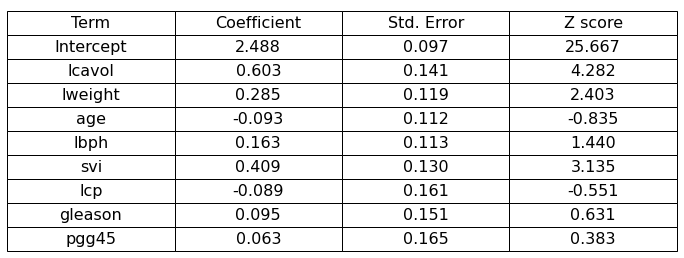

In [ ]:
ds = pd.read_csv("prostate.data.txt","\t",index_col=0)
labels=["lcavol","lweight","age",'lbph','svi','lcp','gleason','pgg45']
y=ds.iloc[0: ,  -2].values
X=ds.iloc[0: , :-2].values
  
#---------------Split 80 20----------------#
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=random.randint(1,50))
X_train = scale(X_train)
X_test  = scale(X_test)


#----Adding column of 1s for intercept-----#
X_train = addOneCol(X_train)
X_test  = addOneCol(X_test)

#-------Beta, Predict, Baseline-------#
beta = getBeta(X_train,y_train)
predictions=predict(X_test,beta)
y_avg= y.mean()

baseline=[]
for i in range(0,len(y_test)):
  baseline.append(y_avg)

print(f'Base error:\t {mean_squared_error(y_test, baseline)}')
print(f'Training error:\t {mean_squared_error(y_train,predict(X_train,beta))}')
print(f'Test error:\t {mean_squared_error(y_test, predictions)}')


#----Getting Statistics-----#
#https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error

varbeta = var_B(X_train,y_test,predictions,beta)
std=[]
zScore=[]
for i in range(0,len(labels)+1):
  standard_error = 2*varbeta[i, i] ** 0.5
  std.append(standard_error)
  zScore.append(beta[i]/std[i])

#----Statistic Table----Linear-----#
columns=['Term','Coefficient','Std. Error', 'Z score']
labels=["Intercept","lcavol","lweight","age",'lbph','svi','lcp','gleason','pgg45']
cell_text=[]

for i in range(0,len(labels)):
  cell_text.append([labels[i],f"{beta[i]:.3f}",f"{std[i]:.3f}",f"{zScore[i]:.3f}"])


fig=plt.figure()
sTable=plt.table(cellText=cell_text,colLabels=columns,cellLoc='center',loc="upper center")
sTable.set_fontsize(16)
sTable.scale(2,2)


#-----Removing Graph-----#
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

for pos in ['right','top','bottom','left']:
  plt.gca().spines[pos].set_visible(False)

#----Correlation Table----#
pd.set_option('display.max_colwidth',1000)
ds.corr()

**Comments**
---
Correlation table is quite close to Table 2.2 of the textbook. It might be off because I dont know what values they took the correlation from.

The coefficient table looks very very close to what Table 2.3 shows. It is not exact because they use the first 80% of datapoints while I use a random 80%.

Overall, linear regression gives me something about 50% or more less error than the baseline as the textbook states.

# Ridge (Prostate)

'best' lambda:		35.44366366366366
base error:		1.8196714880761653
train error:		0.5317446636354641
final error:		0.5711545217476768


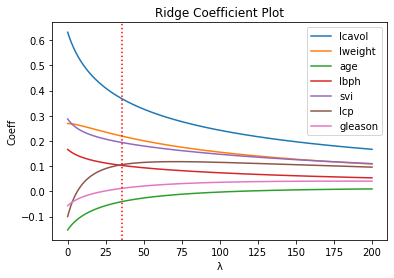

In [ ]:
ds = pd.read_csv("prostate.data.txt","\t",index_col=0)
labels=["lcavol","lweight","age",'lbph','svi','lcp','gleason','pgg45']
X=ds.iloc[:, :-2].values
y=ds.iloc[:,  -2].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=random.randint(1,50))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125,random_state=1)

#------Standardizing----------#
sc=StandardScaler()
X_train=scale(X_train)
X_test=scale(X_test)

#------Ridge Regression-------#
#-------Finding Lambda--------#
beta_o        = y_train.mean()
data          = []  #Holds the beta coefficients for each iteration
l_span        = np.linspace(0.01,200,num=1000)
best_l = findRidgeLambda(X_train, y_train, X_val, y_val, l_span, beta_o, data)
best_beta=ridgeBeta(X_train,y_train,best_l)

abels=["lcavol","lweight","age",'lbph','svi','lcp','gleason','pgg45']

for i in range(0,7):
  x_data=[j[i] for j in data]
  plt.plot(l_span,x_data,label=labels[i])

plt.axvline(best_l,linestyle=":",c="r")
plt.title("Ridge Coefficient Plot"), plt.xlabel("λ"), plt.ylabel("Coeff")
plt.legend()

#---------Printing Useful Info----------#
y_avg=y.mean()
baseline=[y_avg for i in range(0,len(y_test))]

print("'best' lambda:\t\t"+str(best_l))

print("base error:\t\t" + str(mean_squared_error(y_test,baseline)))

print("train error:\t\t"+ str(mean_squared_error(y_train,beta_o+predict(X_train,best_beta))))

print("final error:\t\t"+ str(mean_squared_error(y_test,beta_o+predict(X_test,best_beta))))

**Comments**
---
Ridge regression gives final error values relatively close to the training errors.

 Our method of cross validation is selecting a random 10% of the training data as validation and testing the error, 5 times for each lambda. We average the errors to see which lambda is the best overall at making good consistent predictions on unseen data.

# Lasso (Prostate)

best lambda:		0.0019849659318637277
base error:		1.5105905375948674
train error:		0.41179860045113126
final error:		0.5036786411095342


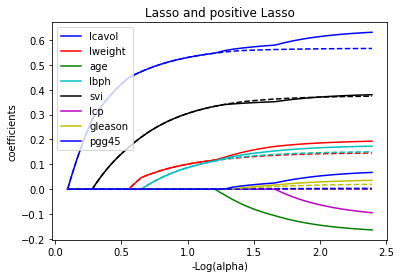

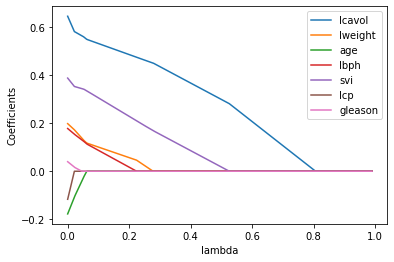

In [ ]:
ds = pd.read_csv("prostate.data.txt","\t",index_col=0)
labels=["lcavol","lweight","age",'lbph','svi','lcp','gleason','pgg45']
X=ds.iloc[0:, :-2].values
y=ds.iloc[0:,  -2].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=random.randint(1,50))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125,random_state=1)

#------Standardizing----------#
sc=StandardScaler()
X_train=scale(X_train)
X_val=scale(X_val)
X_test=scale(X_test)


#-----Finding best lambda-------#
cf=Lasso()
best_l=0
best_mse=999999
data=[]
l_span=np.linspace(0.000001,0.99,500)

best_l = findLassoLambda(X_train, y_train, X_val, y_val, l_span, data)

#----------Lasso Plot-------------#
#From https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html
labels=["lcavol","lweight","age",'lbph','svi','lcp','gleason','pgg45']
eps = 5e-3 
labIt=0 #Label iterator
colors = cycle(['b', 'r', 'g', 'c', 'k','m','y'])
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps, fit_intercept=False)
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(X_train, y_train, eps=eps, positive=True, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

plt.figure()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c,label=labels[labIt])
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)
    labIt=labIt+1
    

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.legend()
plt.axis('tight')    


#---------Lambda Plot--------------#
plt.figure()

for i in range(0,7):
  x_data=[j[i] for j in data]
  plt.plot(l_span,x_data,label=labels[i])
plt.legend()
plt.xlabel('lambda'), plt.ylabel('Coefficients')

#---------Printing Useful Info----------#
y_avg=y.mean()
baseline=[y_avg for i in range(0,len(y_test))]
print("best lambda:\t\t"+str(best_l))
print("base error:\t\t" + str(mean_squared_error(y_test,baseline)))
cf.set_params(alpha=best_l)
cf.fit(X_train,y_train)
print("train error:\t\t" + str(mean_squared_error(y_train,cf.predict(X_train))))
print("final error:\t\t"+ str(mean_squared_error(y_test,cf.predict(X_test))))

**Comments**
---
Lasso regression works similiarly in effectiveness as with ridge regression, the train error and test error are relatively near each other. This can be improved by better cross-validation.

# Lasso (Ozone)


**Features** 
---
1. vh : Vandenberg 500 mb Height
2. wind : Wind Speed (mph)
3. humidity : Humidity (%)
4. temp : Sandburg AFB Temperature
5. ibh : Inversion Base Height
6. dpg : Daggot Pressure Gradient
7. ibt : Inversion Base Temperature
8. vis : Visibility (miles)

**LABEL** (Y)
---
1. ozone : Upland,CA  maximum Ozone

**INDEXING**
---
1. Day of the year 

[[-0.23260916  0.52749784 -0.23481473  1.29976499]
 [ 0.21292243  0.31933846  0.18302518  0.99670987]
 [ 0.36143296  1.22136244 -0.72847459  0.36304918]
 ...
 [-0.97516181  1.56829475 -1.22434818 -0.84917128]
 [-1.91572851 -0.16636676 -1.20221097 -1.20732733]
 [ 0.31192945  0.249952   -0.98471284  0.25284732]]
best lambda:		0.5585836459114779
base error:		76.8512029384757
train error:		20.135679380561587
final error:		25.421449612959684


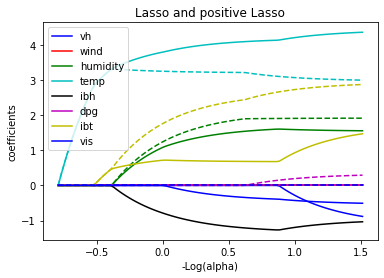

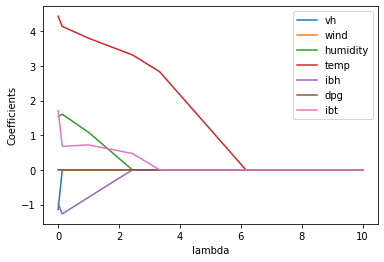

In [ ]:
ds = pd.read_csv("ozone.data.txt",",",index_col=9)
X=ds.iloc[0:, 1:].values
y=ds.iloc[0:,  0].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125,random_state=1)

#------Standardizing----------#
sc=StandardScaler()
X_train=scale(X_train)
X_val=scale(X_val)
X_test=scale(X_test)
print(X_train[:,2:6])

#-----Finding best lambda-------#
cf=Lasso()
best_l=0
best_mse=999999
data=[]
l_span=np.linspace(0.001,10,4000)

best_l = findLassoLambda(X_train, y_train, X_val, y_val, l_span, data)

#----------Lasso Plot-------------#
#From https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html
labels=['vh','wind','humidity','temp','ibh','dpg','ibt','vis']
eps = 5e-3 
labIt=0 #Label iterator
colors = cycle(['b', 'r', 'g', 'c', 'k','m','y'])
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps, fit_intercept=False)
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(X_train, y_train, eps=eps, positive=True, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

plt.figure()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c,label=labels[labIt])
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)
    labIt=labIt+1
    

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.legend()
plt.axis('tight')  
#---------Lambda Plot--------------#
plt.figure()

for i in range(0,7):
  x_data=[j[i] for j in data]
  plt.plot(l_span,x_data,label=labels[i])
plt.legend()
plt.xlabel('lambda'), plt.ylabel('Coefficients')

#---------Printing Useful Info----------#
y_avg=y.mean()
baseline=[y_avg for i in range(0,len(y_test))]
print("best lambda:\t\t"+str(best_l))
print("base error:\t\t" + str(mean_squared_error(y_test,baseline)))

cf.set_params(alpha=best_l)
cf.fit(X_train,y_train)
print("train error:\t\t" + str(mean_squared_error(y_train,cf.predict(X_train))))
print("final error:\t\t"+ str(mean_squared_error(y_test,cf.predict(X_test))))


**Comments**
---
The features selected by the lasso model are temperature, ibt, and humidity. 

This makes sense as higher **temperature** is known to be correlated to higher ozone. 

**higher ibt** is also documented to have a great effect on the concentration of pollutants in the air, which makes sense to correlate to higher ozone levels. 

**Humidity** is a bit more complex, as sources online say that dryer environments  are conducive to ozone formation. The coefficient calculated for it using lasso regression is positive though. Looking at the data directly this is not surprising as humidity levels jump randomly for even days where the ozone value is same.



#Lasso (Ozone optimized)

best lambda:		0.643596399099775
base error:		76.8512029384757
train error:		18.87066538015203
final error:		24.821434932154038


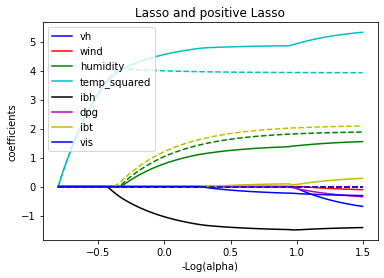

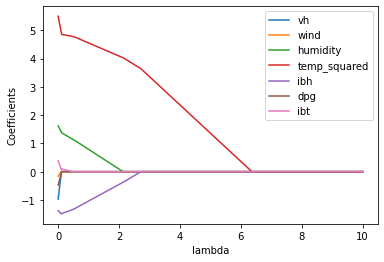

In [ ]:
ds = pd.read_csv("ozone.data.txt",",",index_col=9)
X=ds.iloc[0:, 1:].values
y=ds.iloc[0:,  0].values
X[:,4] = np.square(X[:,4])
X[:,7] = np.square(X[:,7])
X[:,3] = np.square(X[:,3])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125,random_state=1)

#------Standardizing----------#
sc=StandardScaler()
X_train=scale(X_train)
X_val=scale(X_val)
X_test=scale(X_test)

#-----Finding best lambda-------#
cf=Lasso()
best_l=0
best_mse=999999
data=[]
l_span=np.linspace(0.001,10,4000)

best_l = findLassoLambda(X_train, y_train, X_val, y_val, l_span, data)

#----------Lasso Plot-------------#
#From https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html
labels=['vh','wind','humidity','temp_squared','ibh','dpg','ibt','vis']
#labels=['LOL']
eps = 5e-3 
labIt=0 #Label iterator
colors = cycle(['b', 'r', 'g', 'c', 'k','m','y'])
#colors = cycle(['b'])
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps, fit_intercept=False)
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(X_train, y_train, eps=eps, positive=True, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

plt.figure()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c,label=labels[labIt])
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)
    labIt=labIt+1
    

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.legend()
plt.axis('tight')  
#---------Lambda Plot--------------#
plt.figure()

for i in range(0,7):
  x_data=[j[i] for j in data]
  plt.plot(l_span,x_data,label=labels[i])
plt.legend()
plt.xlabel('lambda'), plt.ylabel('Coefficients')

#---------Printing Useful Info----------#
y_avg=y.mean()
baseline=[y_avg for i in range(0,len(y_test))]
print("best lambda:\t\t"+str(best_l))
print("base error:\t\t" + str(mean_squared_error(y_test,baseline)))

cf.set_params(alpha=best_l)
cf.fit(X_train,y_train)
print("train error:\t\t" + str(mean_squared_error(y_train,cf.predict(X_train))))
print("final error:\t\t"+ str(mean_squared_error(y_test,cf.predict(X_test))))


#**Variable selection**
According to our analysis from the previous section of ozone using Lasso, we figured out that the three most impactful variables are humidity, ibt and temperature. We decided to square all three of those values and try to check the errors again to see if it has improved.
#**Comment**
Our result show that the error did go down a bit from the state that we had before, but it is not a huge change which does not necessary mean that the squared of those three value will have a huge impact.

We attempted different nonlinear transformations on the data set such as logarithms and taking a ratio of tempature and humidity, for example, but all of them lead to worse or roughly equal MSE compared to the default data set. 

Although it is unlikely that the features have a linear relationship with the label, we were not able to find a transformation that lead to consistently better results.